El dataset tiene las transacciones de usuarios que realizaron en una determinada tienda 
de Uruguay. El dataset tiene el numero de la factura, el id del usuario, la fecha, el valor del producto
y el id del producto. Una misma factura puede tener mas de un producto

# Libraries

In [ ]:
#install.packages('hexbin')

In [44]:
library(tidyverse)
library(lubridate)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




# Load Raw Dataset
EL dataset tiene las columnas:
* Factura
* Fecha
* Customer_ID
* Sexo
* Venta ($)
* Ciudad
* Product ID

In [95]:
col_types <- cols(
    Factura = col_character(),
    Fecha = col_character(),
    Customer_ID = col_character(),
    Sexo = col_character(),
    `Venta ($)` = col_character(),
    Ciudad = col_character(),
    `Product ID` = col_integer()
)
df <- readr::read_delim('../data/Final Project Dataset.csv', ',', col_types = col_types)

# Parse correct data types

In [96]:
df$Fecha <- parse_date(df$Fecha, "%d/%m/%Y")
df <- rename(df, Precio_Venta = 'Venta ($)')
df <- rename(df, Product_ID = 'Product ID')
df$Precio_Venta_2 <- parse_number(df$Precio_Venta, locale = locale(decimal_mark = ",", grouping_mark = "."), na = c("", "NA", "--"))


Warning message:
“2626 parsing failures.
row col expected actual
258  -- a number      -
275  -- a number      -
293  -- a number      -
481  -- a number      -
557  -- a number      -
... ... ........ ......
See problems(...) for more details.
”


In [97]:
head(df)

Factura,Fecha,Customer_ID,Sexo,Precio_Venta,Ciudad,Product_ID,Precio_Venta_2
<chr>,<date>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
227837,2019-08-23,175335,#ERROR!,2.901,Rivera,4,2901
227832,2019-08-23,140862,#ERROR!,7.256,Montevideo Periferia,19,7256
227831,2019-08-23,225831,#ERROR!,2.901,Durazno,4,2901
227826,2019-08-23,185845,#ERROR!,4.462,Montevideo Periferia,0,4462
227823,2019-08-23,153566,#ERROR!,2.901,Rivera,4,2901
227821,2019-08-23,164715,#ERROR!,2.214,Paysandú,3,2214


# Cleanning and transformation

## missing values

In [115]:
cheack_missing <- function(df){
    t(data.frame(n_missing = sapply(df, function(x) sum(is.na(x))),
                 perc_missing = sapply(df, function(x) as.integer(mean(is.na(x))*100))))
}
cheack_missing(df)                                                             

,Factura,Fecha,Customer_ID,Sexo,Precio_Venta,Ciudad,Product_ID,Precio_Venta_2
n_missing,9377,0,1,0,0,0,0,2626
perc_missing,14,0,0,0,0,0,0,4


## Facturas son valor?
Posible estrategia seria llenar con un numero random todas las compras de un usuario en el mismo dia


## Filtrado de las transacciones validas 

In [107]:
df_clean <- df %>% 
    filter(!is.na(Precio_Venta_2), !is.na(Factura), !is.na(Customer_ID))

In [116]:
cheack_missing(df_clean)

,Factura,Fecha,Customer_ID,Sexo,Precio_Venta,Ciudad,Product_ID,Precio_Venta_2
n_missing,0,0,0,0,0,0,0,0
perc_missing,0,0,0,0,0,0,0,0


In [100]:
summary(df_clean)

   Factura              Fecha            Customer_ID            Sexo          
 Length:54073       Min.   :2018-01-02   Length:54073       Length:54073      
 Class :character   1st Qu.:2018-06-25   Class :character   Class :character  
 Mode  :character   Median :2018-11-21   Mode  :character   Mode  :character  
                    Mean   :2018-11-21                                        
                    3rd Qu.:2019-03-30                                        
                    Max.   :2019-08-31                                        
 Precio_Venta          Ciudad            Product_ID    Precio_Venta_2 
 Length:54073       Length:54073       Min.   : 0.00   Min.   :  403  
 Class :character   Class :character   1st Qu.: 1.00   1st Qu.: 2904  
 Mode  :character   Mode  :character   Median : 5.00   Median : 4635  
                                       Mean   : 6.88   Mean   : 4739  
                                       3rd Qu.: 9.00   3rd Qu.: 5881  
                     

## Feature engineering

### Detalle de la compra

In [158]:
resumen_compra <- df_clean %>% 
    group_by(Factura) %>% 
    summarise(n_prod = n(),
              total_venta = sum(Precio_Venta_2),
             ) %>% 
    ungroup()

resumen_compra[sample(nrow(resumen_compra), 10),]

`summarise()` ungrouping output (override with `.groups` argument)



Factura,n_prod,total_venta
<chr>,<int>,<dbl>
21001284,1,7260
22006216,1,6171
16007295,1,2416
223285,1,6531
22000902,1,3953
19004873,1,6046
19007509,1,6046
22007705,1,6168
17002753,1,6050


### Detalles de la factura

In [168]:
feactura <- df_clean %>% 
    distinct(Factura, Fecha, Customer_ID, Ciudad, Dias_Ultima_Compra) %>% 
    mutate(Dias_Ultima_Compra = as.integer(max(Fecha) - Fecha))

head(feactura)

Factura,Fecha,Customer_ID,Ciudad,Dias_Ultima_Compra
<chr>,<date>,<chr>,<chr>,<int>
227837,2019-08-23,175335,Rivera,8
227832,2019-08-23,140862,Montevideo Periferia,8
227831,2019-08-23,225831,Durazno,8
227826,2019-08-23,185845,Montevideo Periferia,8
227823,2019-08-23,153566,Rivera,8
227821,2019-08-23,164715,Paysandú,8


### Detalles del customer

`summarise()` ungrouping output (override with `.groups` argument)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



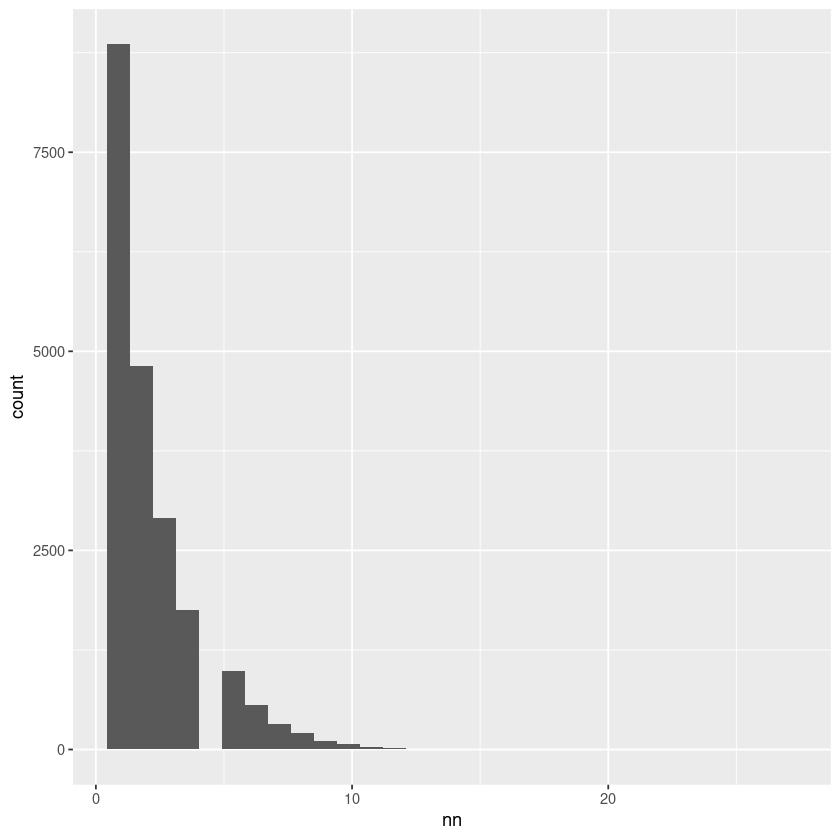

In [185]:
# Diversidad de compra
df_clean %>% 
    group_by(Customer_ID) %>%
    summarise(nn = n_distinct(Product_ID)) %>%
    arrange(nn) %>% 
    ggplot(aes(nn)) + geom_histogram()

In [164]:
resumen_factura <- feactura %>% inner_join(resumen_compra, by = "Factura")
head(resumen_factura)

Factura,Fecha,Customer_ID,Ciudad,Dias_Ultima_Compra,n_prod,total_venta
<chr>,<date>,<chr>,<chr>,<int>,<int>,<dbl>
227837,2019-08-23,175335,Rivera,8,1,2901
227832,2019-08-23,140862,Montevideo Periferia,8,1,7256
227831,2019-08-23,225831,Durazno,8,1,2901
227826,2019-08-23,185845,Montevideo Periferia,8,1,4462
227823,2019-08-23,153566,Rivera,8,1,2901
227821,2019-08-23,164715,Paysandú,8,1,2214


In [170]:
customer  <- resumen_factura %>% 
    group_by(Customer_ID) %>% 
    summarise(n_compras = n(),
              n_productos = sum(n_prod),
              ultimo_dia = min(Dias_Ultima_Compra)
             ) %>% 
    arrange(n_compras)
head(customer)

`summarise()` ungrouping output (override with `.groups` argument)



Customer_ID,n_compras,n_productos,ultimo_dia
<chr>,<int>,<int>,<int>
06444-,1,1,38
100032,1,1,49
100046,1,1,549
100058,1,1,158
100081,1,1,446
100114,1,1,53


In [171]:
customer %>% mutate(x = ultimo_dia > 400) %>% select(x) %>% summarise(x_mean=mean(x))

x_mean
<dbl>
0.1655687


Warning message:
“Removed 4 rows containing missing values (geom_point).”


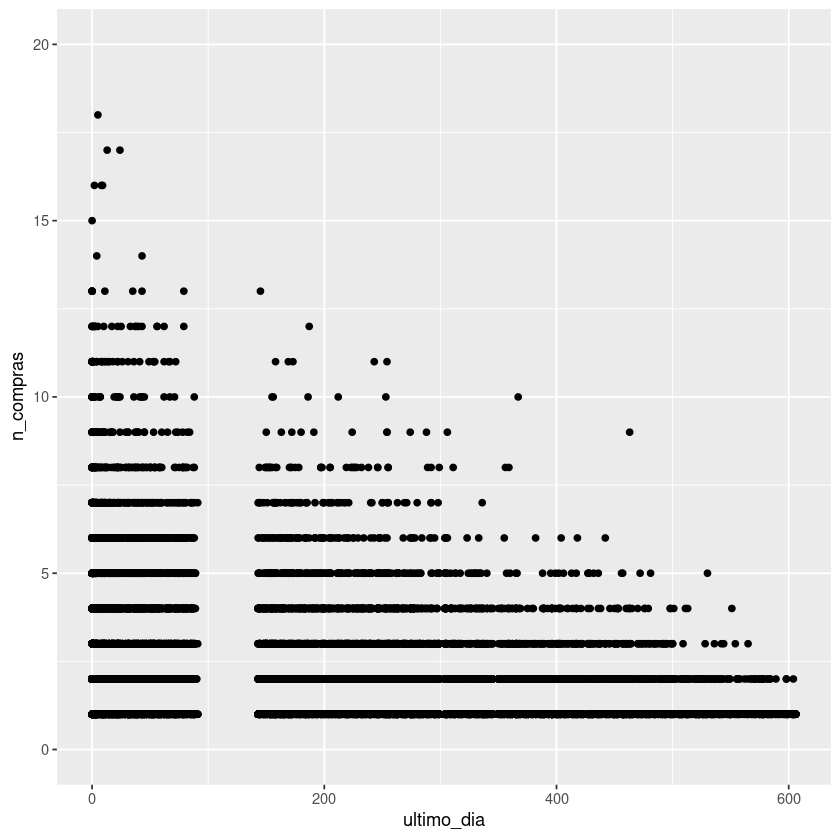

In [173]:
customer %>% ggplot(aes(x=ultimo_dia, y=n_compras)) + geom_point()+ ylim(0, 20)

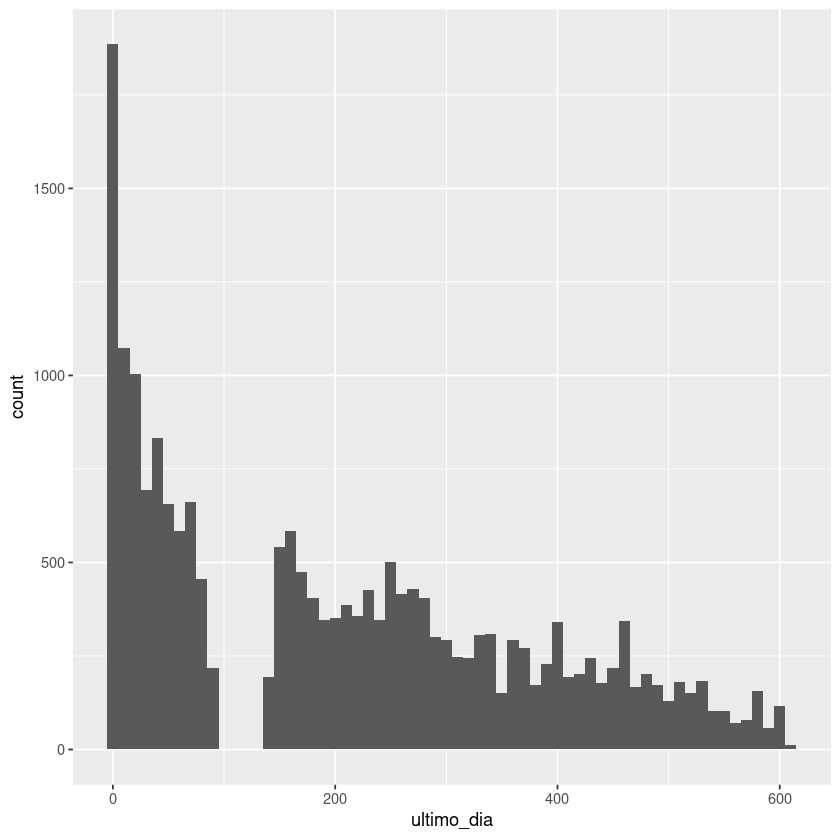

In [175]:
customer %>% ggplot(aes(x=ultimo_dia)) + geom_histogram(binwidth = 10)

In [92]:
df_clean %>% count(Product_ID)

Product_ID,n
<int>,<int>
0,9294
1,6443
2,6631
3,3786
4,4898
5,3883
6,4495
7,3625
8,2907
